# COMP90051 Project 2

Haonan Zhong 867492

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Optional, Tuple, Callable

from sklearn.linear_model import LogisticRegression  # for Part 4

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Parts 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
    
    @abstractmethod
    def play(self, context: Optional[ndarray] = None) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
    
    @abstractmethod
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
            
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))                       

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Parts 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds: # Note: fixed
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, reward, contexts[i])
            matched_ctr += 1
            matched_ids.append(i)
    
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required
arm_ids = [i for i in range(10)]
n_experiments = 20

def plot_results(results, label=None):
    """
    Plot pre-round cumulative reward of a given reward list
    Taken from COMP90051 Workshop 9 Notebook
    
    Parameters
    ----------
    results : ndarray
        Rewards

    Returns
    -------
    None
    """
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=label, linewidth=0.6)

def retrieve_pulls(ids):
    """
    Retrieve the pull number of arms from a given list of ids
    """

    played_arms = [arms[i] for i in ids]
    count = []
    for i in arm_ids:
        count.append(played_arms.count(i))

    return count

## Part 1: Thompson sampling MAB

In [5]:
class TS(MAB):
    """Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    alpha0: float, optional
        positive real prior hyperparameter

    beta0: float, optional
        positive real prior hyperparameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, alpha0: float = 1.0, beta0: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)

        self.alpha0 = float(alpha0)
        self.beta0 = float(beta0)
        
        if self.alpha0 <= 0 or self.beta0 <= 0:
            raise ValueError("`beta` and `alpha` must be greater than 0")

        self.S = np.full(self.n_arms, self.alpha0, dtype=float)
        self.F = np.full(self.n_arms, self.beta0, dtype=float)
        
    def play(self, context: Optional[ndarray] = None) -> int:
        # Compute theta for each arm
        theta = self.rng.beta(self.S, self.F)
        # Find the arm with the maximum theta, tie break if there are multiple
        max_arm = self.rng.choice(np.argwhere(theta==theta.max()).flatten())
        return max_arm
        
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)

        if reward == 1:
            self.S[arm] += 1
        elif reward == 0:
            self.F[arm] += 1
        else:
            raise ValueError("`reward` should be with value either 0 or 1") 

Load Dataset

In [6]:
file_path = "../code/dataset.txt"

arms, rewards, features = [], [], []
count = 0
data = open(file_path, 'r')

for line in data:
    count += 1
    cols = line.split()
    arms.append(int(cols[0]))
    rewards.append(float(cols[1]))

    feature = cols[2:]
    feature = [float(element) for element in feature]
    features.append(feature)


arms = np.array(arms)
rewards = np.array(rewards)
features = np.array(features)
# reshape the context of each event into the required size
contexts = features.reshape(count, 10, 10)

In [10]:
mab = TS(10, alpha0=1, beta0=1, rng=rng)
TS_rewards, TS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('TS average reward', np.mean(TS_rewards))

TS average reward 0.21125


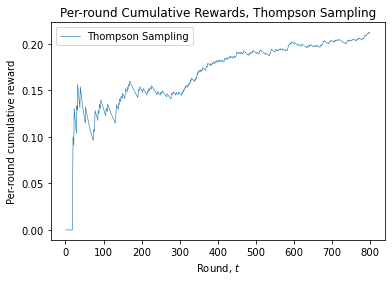

In [11]:
plot_results(TS_rewards, label="Thompson Sampling")
plt.legend()
plt.title('Per-round Cumulative Rewards, Thompson Sampling')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $\alpha_0$ and $\beta_0$, after running each candidate for 20 experiments, on average the mean rewards are highest when alpha and beta is small, which is approximately 0.15 in our search space. And as we can see from the plot below, the mean rewards decreases as the value of alpha and beta increases.

Maximum average reward = 0.234375, Alpha = Beta = 0.15000000000000002


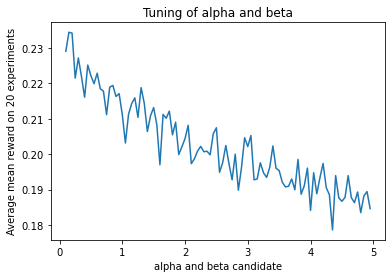

In [17]:
candidate = np.arange(0.1, 5, 0.05)
reward_list = []
for i in candidate:
    mean_rewards_sum = 0
    for _ in range(n_experiments):
        mab = TS(10, alpha0=i, beta0=i, rng=rng)
        tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
        mean_rewards_sum += np.mean(tune_rewards)
    reward_list.append(mean_rewards_sum / n_experiments)

max_index = np.argmax(reward_list)
print('Maximum average reward = ' + str(reward_list[max_index]) + ', Alpha = Beta = ' + str(candidate[max_index]))
plt.plot(candidate, reward_list)
plt.title('Tuning of alpha and beta')
plt.xlabel('alpha and beta candidate')
plt.ylabel('Average mean reward on ' + str(n_experiments) + ' experiments')
plt.show()

## Part 2: Thompson sampling contextual MAB with linear payoffs

In [18]:
class LinTS(MAB):
    """Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
        
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """    
    def __init__(self, n_arms: int, n_dims: int, v: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        self.n_dims = int(n_dims)
        self.v = float(v)

        if self.n_dims <= 0:
            raise ValueError("`n_dims` must be greater than 0")
        if self.v <= 0:
            raise ValueError("`v` must be a positive real number")

        self.B = np.identity(self.n_dims)
        self.mu_hat = np.zeros((self.n_dims, 1))
        self.f = np.zeros((self.n_dims, 1))
        
    def play(self, context: Optional[ndarray] = None) -> int:
        mu_flatten = self.mu_hat.reshape(10)
        posterior_covariance = self.v**2 * np.linalg.inv(self.B)
        # sample mu_t from multivariate normal distribution
        sample_mu = self.rng.multivariate_normal(mu_flatten, posterior_covariance)
        
        # compute the estimate and find arm with maximum value, if there's multiple break tie randomly
        est = np.array([np.dot(context[arm], sample_mu) for arm in range(self.n_arms)])
        max_arm = self.rng.choice(np.argwhere(est == est.max()).flatten())
        
        return max_arm

    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward)

        b_at = context[arm]#.reshape(self.n_dims, 1)
        self.B += np.outer(b_at, b_at)
        self.f += np.dot(float(reward), b_at).reshape(10, 1)
        self.mu_hat = np.dot(np.linalg.inv(self.B), self.f)

In [21]:
mab = LinTS(10, 10, v=1, rng=rng)
LinTS_rewards, LinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('LinTS average reward', np.mean(LinTS_rewards))

LinTS average reward 0.315


Plot per-round cumulative reward for TS and LinTS on the same set of axes

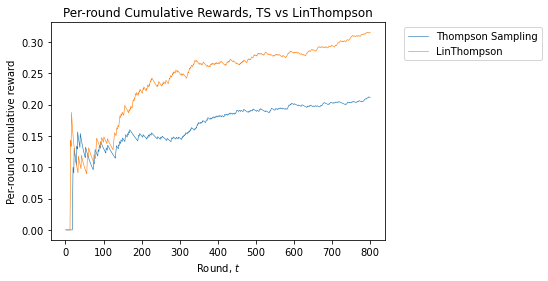

In [22]:
plot_results(TS_rewards, label="Thompson Sampling")
plot_results(LinTS_rewards, label="LinThompson")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Per-round Cumulative Rewards, TS vs LinThompson')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $v$, we can see that the average mean rewards are highest when $v$ is samll, approximately 0.01 in our search space, and as we can see from the plot below, the average mean rewards decreases as the candidate value of $v$ increases.

Maximum average mean reward = 0.43543750000000003, V = 0.01


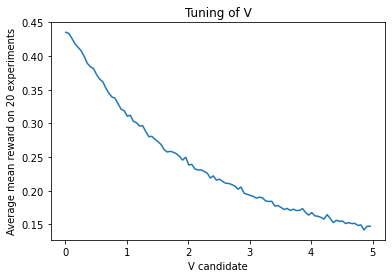

In [23]:
candidate = np.arange(0.01, 5, 0.05)
reward_list = []
for i in candidate:
    mean_rewards_sum = 0
    for _ in range(n_experiments):
        mab = LinTS(10, 10, v=i, rng=rng)
        tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
        mean_rewards_sum += np.mean(tune_rewards)
    reward_list.append(mean_rewards_sum / n_experiments)

max_index = np.argmax(reward_list)
print('Maximum average mean reward = ' + str(reward_list[max_index]) + ', V = ' + str(candidate[max_index]))
plt.plot(candidate, reward_list)
plt.title('Tuning of V')
plt.xlabel('V candidate')
plt.ylabel('Average mean reward on ' + str(n_experiments) + ' experiments')
plt.show()

## Part 3: Thompson sampling MABs with fair exposure

In [24]:
class FairXTS(TS):
    """FairX Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    alpha0: float, optional
        Positive real prior hyperparameter.

    beta0: float, optional
        Positive real prior hyperparameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, c: float = 1.0, alpha0: float = 1.0, 
                 beta0: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, alpha0, beta0, rng)
        self.c = float(c)
    
    def play(self, context: Optional[ndarray] = None) -> int:
        mu_t = self.rng.beta(self.S, self.F)
        policy_numerator = np.exp(np.array(mu_t) * self.c)
        pi_t = policy_numerator/sum(policy_numerator)

        # return the sampled arm based on the given pi_t
        return self.rng.choice(arm_ids, p=pi_t)

In [25]:
mab = FairXTS(10, c=1, alpha0=1, beta0=1, rng=rng)
FairXTS_rewards, FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-TS average reward', np.mean(FairXTS_rewards))

FairX-TS average reward 0.12125


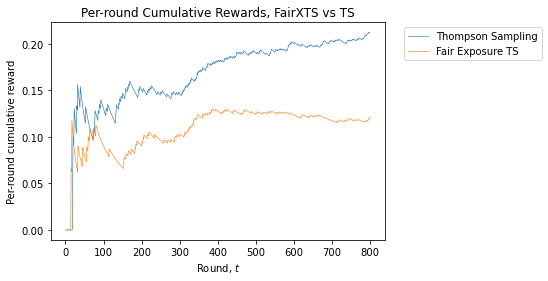

In [26]:
plot_results(TS_rewards, label="Thompson Sampling")
plot_results(FairXTS_rewards, label="Fair Exposure TS")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Per-round Cumulative Rewards, FairXTS vs TS')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Retrieve arms pulled and the corresponding number of pulls

In [27]:
TS_count = retrieve_pulls(TS_ids)
FairXTS_count = retrieve_pulls(FairXTS_ids)

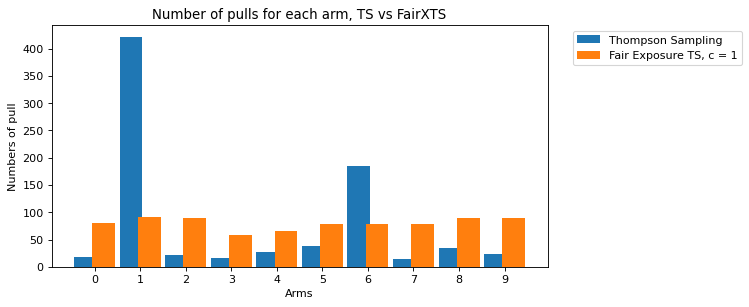

In [28]:
X_axis = np.arange(len(arm_ids))
plt.figure(figsize=(8, 4), dpi=80)
plt.bar(X_axis - 0.2, TS_count, 0.5, label='Thompson Sampling')
plt.bar(X_axis + 0.2, FairXTS_count, 0.5, label='Fair Exposure TS, c = 1')
plt.xticks(arm_ids)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Arms')
plt.ylabel('Numbers of pull')
plt.title('Number of pulls for each arm, TS vs FairXTS')
plt.show()

When comparing the number of pulls for each arm between the two, the number of pulls for each arm are more uniformly distributed in Fair Exposure TS, while in TS the pulls for heavily focused on one arm. The difference are due to the basic Thompson Sampling adopts the winner-takes-all allocation, while Fair Exposure TS allows each arm receives a certain amount of exposure proportional to its merit, and explore more.

In [29]:
mab = FairXTS(10, c=10, alpha0=1, beta0=1, rng=rng)
FairXTS_rewards, FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-TS average reward', np.mean(FairXTS_rewards))

FairX-TS average reward 0.15375


However, as we increases the value of $c$ in the fair exposure setting, we can see the number of pulls for each arm starts to resemble the one from basic Thompson Sampling.

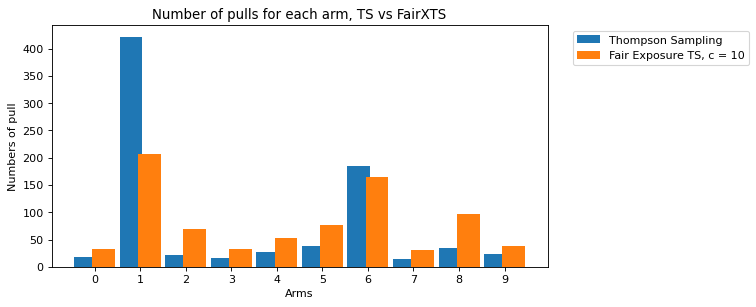

In [30]:
FairXTS_count = retrieve_pulls(FairXTS_ids)
plt.figure(figsize=(8, 4), dpi=80)
plt.bar(X_axis - 0.2, TS_count, 0.5, label='Thompson Sampling')
plt.bar(X_axis + 0.2, FairXTS_count, 0.5, label='Fair Exposure TS, c = 10')
plt.xticks(arm_ids)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Arms')
plt.ylabel('Numbers of pull')
plt.title('Number of pulls for each arm, TS vs FairXTS')
plt.show()

In [31]:
class FairXLinTS(LinTS):
    """FairX Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
    
    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, c: float = 1.0, 
                 v: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, n_dims, v, rng)
        self.c = float(c)
    
    def play(self, context: Optional[ndarray] = None) -> int:
        mu_flatten = self.mu_hat.reshape(10)
        posterior_covariance = self.v**2 * np.linalg.inv(self.B)
        # sample mu_t from multivariate normal distribution
        sample_mu = self.rng.multivariate_normal(mu_flatten, posterior_covariance)
        est = np.array([np.dot(context[arm], sample_mu) for arm in range(self.n_arms)])

        # scale each estimation with c and apply the merit function
        policy_numerator = np.exp(est * self.c)
        # construct the policy of round t    
        pi_t = np.array(policy_numerator)/sum(policy_numerator)

        return self.rng.choice(arm_ids, p=pi_t)

In [46]:
mab = FairXLinTS(10, 10, c=1.0, v=1, rng=rng)
FairXLinTS_rewards, FairXLinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-LinTS average reward', np.mean(FairXLinTS_rewards))

FairX-LinTS average reward 0.13125


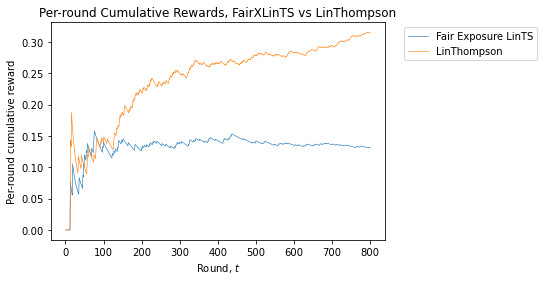

In [47]:
plot_results(FairXLinTS_rewards, label="Fair Exposure LinTS")
plot_results(LinTS_rewards, label="LinThompson")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Per-round Cumulative Rewards, FairXLinTS vs LinThompson')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

## Task 4: SquareCB contextual MAB with a logistic regression oracle

In [77]:
class SquareCB(MAB):
    """SquareCB contextual MAB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float, optional
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)

        self.n_dims = n_dims
        self.gamma = gamma
        self.mu = n_arms  # hard-code parameter μ to be the number of arms

        if self.n_dims <= 0:
            raise ValueError("`n_dims` must be greater than 0")
        if self.gamma <= 0:
            raise ValueError("`gamma` must be greater than 0")

        self.contexts = [[] for i in range(self.n_arms)]  # initialise contexts for arms
        self.rewards = [[] for i in range(self.n_arms)]   # initialise rewards for arms
        self.models = [LogisticRegression() for i in range(self.n_arms)] # initialise a model for each arm
        self.arm_played = [False for i in range(self.n_arms)] 
    
    def play(self, context: Optional[ndarray] = None) -> int:

        scores = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            # if an arm only has one class, randomly assign a value between 0 and 1
            # since we won't be able to train logistic regression with one class
            if self.arm_played[i] == False:
                scores[i] = 1
            else:
                scores[i] = self.models[i].predict_proba(np.asarray(context[i]).reshape(1, -1))[0][0]

        # Find the minimum and mark it's index
        b_t_index = self.rng.choice(np.argwhere(scores == scores.min()).flatten())
        b_t = scores[b_t_index]

        p_t = np.zeros(self.n_arms)
        for i in range(self.n_arms):
            if i != b_t_index:
                p_t[i] = 1 / (self.mu + self.gamma * (scores[i] - b_t))

        p_t[b_t_index] = 1 - sum(p_t)
        return self.rng.choice([arm for arm in range(10)], p=p_t)
    
    def update(self, arm: int, reward: float, 
               context: Optional[ndarray] = None) -> None:

        self.contexts[arm].append(context[arm].flatten())
        self.rewards[arm].append(reward)

        # check if there's two class for rewards
        # since logistic regression needs to have two class to operate
        # fit the model is condition satisfied
        if len(set(self.rewards[arm])) == 2:
            self.arm_played[arm] = True
            self.models[arm].fit(np.asarray(self.contexts[arm]), np.asarray(self.rewards[arm]))
        

In [81]:
mab = SquareCB(10, 10, gamma=18, rng=rng)
SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.60125


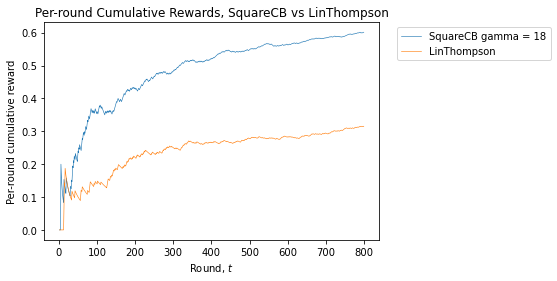

In [82]:
plot_results(SquareCB_rewards, label="SquareCB gamma = 18")
plot_results(LinTS_rewards, label="LinThompson")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Per-round Cumulative Rewards, SquareCB vs LinThompson')
plt.xlabel('Round, $t$')
plt.ylabel('Per-round cumulative reward')
plt.show()

Tuning the value of $\gamma$, as we can see from the plot below, the average mean rewards are increasing as the value of gamma gets bigger.

Maximum average reward = 0.7484375, V = 105


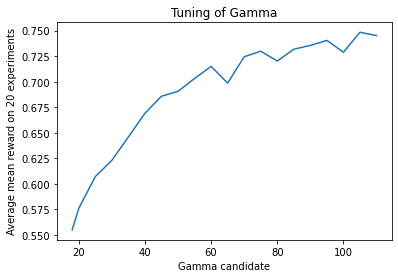

In [69]:
candidate = [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110]
reward_list = []
for i in candidate:
    mean_rewards_sum = 0
    for _ in range(n_experiments):
        mab = SquareCB(10, 10, gamma=i, rng=rng)
        tune_rewards, ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
        mean_rewards_sum += np.mean(tune_rewards)
    reward_list.append(mean_rewards_sum / n_experiments)

max_index = np.argmax(reward_list)
print('Maximum average reward = ' + str(reward_list[max_index]) + ', V = ' + str(candidate[max_index]))
plt.plot(candidate, reward_list)
plt.title('Tuning of Gamma')
plt.xlabel('Gamma candidate')
plt.ylabel('Average mean reward on ' + str(n_experiments) + ' experiments')
plt.show()